Milestone2


In [238]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import numpy as np

# kagglehub.login()


Dataset available at: https://www.kaggle.com/datasets/tonygordonjr/football-match-statistics-and-more/data?fbclid=IwZXh0bgNhZW0CMTEAAR27HPyyqC9nUioeOqJzVzznFoIH3SNY0xcdZ_4dDxEpDOoRnZgcaXdTTRE_aem_0dX5wF1-vk6WmlQWZMnQ2g

In [239]:
# !kaggle datasets download -d tonygordonjr/football-match-statistics-and-more
# !unzip /content/football-match-statistics-and-more.zip -d ./

In [240]:
teams_clean_col = ['fixture_id', 'team_id', 'team_name', 'fouls','yellow_cards', 'red_cards']
stats_clean_col = ['fixture_id', 'fixture_date', 'fixture_referee', 'league_id', 'league_name', 'teams_home_id', 'teams_home_name', 'teams_away_id', 'teams_away_name']
players_clean_col = ['fixture_id', 'team_id', 'team_name', 'player_id', 'player_name', 'fouls_committed', 'yellow_cards', 'red_cards', 'game_minutes']

fix_teams_clean = pd.read_csv("fixture_stats_teams_clean.csv",usecols=teams_clean_col)
fix_clean = pd.read_csv("fixture_stats_clean.csv", usecols=stats_clean_col)
fix_players_clean = pd.read_csv("fixture_stats_players_clean.csv",usecols=players_clean_col)

In [241]:
# team ids are actual identifiers (not like player_ids)
fix_teams_clean.groupby(['team_id', 'team_name']).size().reset_index().team_name.value_counts()

team_name
Bay FC        1
Belgium       1
France        1
Robin Hood    1
Al Riyadh     1
             ..
Colombia      1
Uruguay       1
Brazil        1
Sweden        1
Russia        1
Name: count, Length: 723, dtype: int64

In [242]:
# fixture_date added to the players statistics for further data preparation purposes: fix_players_clean
fix_players_clean = fix_players_clean.merge(fix_clean[['fixture_id', 'fixture_date']], on='fixture_id', how='left')
# fix_players_clean = fix_players_clean_og.copy()

In [243]:
# Összes kapott lap kiszámítása minden játékosra: fix_players_clean
fix_players_clean['total_cards'] = fix_players_clean.apply(lambda x: x['yellow_cards'] + x['red_cards'] * 2 if x['yellow_cards'] != 2 else 3, axis=1)
# fix_players_clean.sort_values('red_cards', ascending=False).head()

fix_players_clean.drop(['yellow_cards', 'red_cards'], axis=1, inplace=True)

In [244]:
# Játékosok kidobása ha game_minutes isna: fix_players_clean
# Ezek a pályán kívül kapott lapok amik nem számítanak bele az összes lap számába a fogadóirodáknál
# fix_players_clean[(fix_players_clean['game_minutes'].isna()) & (fix_players_clean['total_cards'] != 0)].sort_values(by=['total_cards', 'fixture_date'], ascending=[False, False])

fix_players_clean.drop(fix_players_clean[fix_players_clean["game_minutes"].isna()].index, inplace=True)
fix_players_clean["game_minutes"].isna().sum()

np.int64(0)

In [245]:
# Összes kapott lap kiszámításra minden csapatra minden meccsen: fix_total_cards
fix_total_cards = fix_players_clean.groupby(['fixture_id', 'team_id'])['total_cards'].sum().reset_index()
fix_total_cards = fix_total_cards.merge(fix_clean[['fixture_id', 'fixture_date']], on='fixture_id', how='left')

In [246]:
fix_total_cards

fixture_id  team_id  total_cards             fixture_date
0              65       33            2  2018-08-10 19:00:00 UTC
1              65       46            1  2018-08-10 19:00:00 UTC
2              66       34            2  2018-08-11 11:30:00 UTC
3              66       47            2  2018-08-11 11:30:00 UTC
4              67       35            1  2018-08-11 14:00:00 UTC
...           ...      ...          ...                      ...
64871     1316662     1602            2  2024-12-01 00:30:00 UTC
64872     1316663     1595            4  2024-12-01 03:00:00 UTC
64873     1316663     1605            0  2024-12-01 03:00:00 UTC
64874     1318600     1602            2  2024-12-07 21:00:00 UTC
64875     1318600     1605            1  2024-12-07 21:00:00 UTC

[64876 rows x 4 columns]

In [247]:
# Sort by team and fixture_date to ensure past matches come first
fix_total_cards = fix_total_cards.sort_values(by=["team_id", "fixture_date"])

# Compute past average total cards for each team
fix_total_cards["avg_total_cards"] = (
    fix_total_cards.groupby("team_id")["total_cards"]
    .expanding()
    .mean()
    .shift()  # Shift to exclude current row from the average
    .reset_index(level=0, drop=True)
)

# Minden csapat legkorábbi meccsét dropoljuk, mert az avg_total_cards értéke ott nem megállapítható
fix_total_cards = fix_total_cards.drop(fix_total_cards.groupby('team_id')['fixture_date'].idxmin())

In [248]:
# Meccsek adataihoz hozzá adjuk a csapatok átlagos kártyáit: fix_total_cards (és cards_tmp)
# Hazai hozzáadása
cards_tmp = fix_clean.merge(fix_total_cards.drop("fixture_date", axis=1), on="fixture_id", how="inner")
cards_tmp = cards_tmp[cards_tmp["team_id"] == cards_tmp["teams_home_id"]]
cards_tmp = cards_tmp.rename(columns={"total_cards": "home_total_cards_value", "avg_total_cards": "avg_home_total_cards"})
cards_tmp = cards_tmp.drop(columns=["team_id"])

# Vendég kártyáinak hozzáadása
cards_tmp = cards_tmp.merge(fix_total_cards.drop("fixture_date", axis=1), on="fixture_id", how="inner")
cards_tmp = cards_tmp[cards_tmp["team_id"] == cards_tmp["teams_away_id"]]
cards_tmp = cards_tmp.rename(columns={"total_cards": "away_total_cards_value", "avg_total_cards": "avg_away_total_cards"})
cards_tmp = cards_tmp.drop(columns=["team_id"])

cards_tmp["total_cards_value"] = cards_tmp["home_total_cards_value"] + cards_tmp["away_total_cards_value"]

fix_total_cards = cards_tmp[['fixture_id', 'fixture_referee', 'fixture_date', 'home_total_cards_value', 'avg_home_total_cards', 'away_total_cards_value', 'avg_away_total_cards', 'total_cards_value']]

In [249]:
fix_total_cards

fixture_id                   fixture_referee             fixture_date  \
0          566789              Felix Brych, Germany  2020-07-06 18:30:00 UTC   
3            9822  Alfonso Alvarez Izquierdo, Spain  2017-10-01 10:00:00 UTC   
5          203592            Alberto Undiano, Spain  2016-02-27 21:05:00 UTC   
7          203530      Juan Martinez Munuera, Spain  2016-01-16 21:05:00 UTC   
9           27416        Adrian Cordero Vega, Spain  2019-03-15 20:00:00 UTC   
...           ...                               ...                      ...   
64223      132923                        O. Hațegan  2019-10-11 18:45:00 UTC   
64225     1299137            Benoît Bastien, France  2024-09-26 16:45:00 UTC   
64226      350229            Jonas Eriksson, Sweden  2016-09-29 19:05:00 UTC   
64228      971763                         I. Peljto  2023-02-16 17:45:00 UTC   
64230      787729                          I. Bebek  2021-09-30 16:45:00 UTC   

       home_total_cards_value  avg_home_total_cards  away_total_cards_value  \
0                           2              2.000000                       2   
3                           3              2.726190                       3   
5                           4              3.160000                       5   
7                           1              3.473684                       3   
9                           2              2.401361                       2   
...                       ...                   ...                     ...   
64223                       3              2.000000                       5   
64225                       5              2.800000                       4   
64226                       2              3.272727                       3   
64228                       3              2.157143                       3   
64230                       4              2.200000                       2   

       avg_away_total_cards  total_cards_value  
0                  2.122807                  4  
3                  2.890244                  6  
5                  3.250000                  9  
7                  2.631579                  4  
9                  3.349515                  4  
...                     ...                ...  
64223              2.666667                  8  
64225              2.000000                  9  
64226              1.000000                  5  
64228              1.973941                  6  
64230              1.675889                  6  

[32043 rows x 8 columns]

In [250]:
# Sort by referee and fixture_date to ensure past matches come first
fix_total_cards = fix_total_cards.sort_values(by=["fixture_referee", "fixture_date"])

# Compute past average total cards for each referee
fix_total_cards["avg_referee_cards"] = (
    fix_total_cards.groupby("fixture_referee")["total_cards_value"]
    .expanding()
    .mean()
    .shift()  # Shift to exclude current row from the average
    .reset_index(level=0, drop=True)
)

# Minden referee legkorábbi meccsét dropoljuk, mert az avg_referee_cards értéke ott nem megállapítható
fix_total_cards = fix_total_cards.drop(fix_total_cards.groupby('fixture_referee')['fixture_date'].idxmin())

In [251]:
fix_total_cards

fixture_id fixture_referee             fixture_date  \
22807      164203     A.  Woolmer  2019-08-17 14:00:00 UTC   
46230      164233     A.  Woolmer  2019-08-25 11:00:00 UTC   
1024       164245     A.  Woolmer  2019-08-31 14:00:00 UTC   
2534       164259     A.  Woolmer  2019-09-21 14:00:00 UTC   
24503      164287     A.  Woolmer  2019-10-01 19:00:00 UTC   
...           ...             ...                      ...   
32556      657877             NaN  2021-05-30 18:00:00 UTC   
32574      657882             NaN  2021-05-30 18:00:00 UTC   
50921      657881             NaN  2021-05-30 18:00:00 UTC   
56631      657879             NaN  2021-05-30 18:00:00 UTC   
64072      657876             NaN  2021-05-30 18:00:00 UTC   

       home_total_cards_value  avg_home_total_cards  away_total_cards_value  \
22807                       2              2.000000                       1   
46230                       1              1.371951                       5   
1024                        1              2.082474                       7   
2534                        1              1.715054                       2   
24503                       4              1.915789                       0   
...                       ...                   ...                     ...   
32556                       2              2.137931                       2   
32574                       4              1.920000                       6   
50921                       3              1.793651                       1   
56631                       1              2.330709                       3   
64072                       5              2.421053                       2   

       avg_away_total_cards  total_cards_value  avg_referee_cards  
22807              1.975460                  3                3.0  
46230              1.994565                  6                3.0  
1024               1.814433                  8                4.0  
2534               1.754491                  3                5.0  
24503              1.917582                  4                4.6  
...                     ...                ...                ...  
32556              2.020408                  4                NaN  
32574              2.125984                 10                NaN  
50921              2.176000                  4                NaN  
56631              2.500000                  4                NaN  
64072              2.325397                  7                NaN  

[30816 rows x 9 columns]

In [252]:
fix_total_cards.drop(fix_total_cards[fix_total_cards["fixture_referee"].isna()].index, inplace=True)

In [253]:
# Összes falt kiszámítása minden csapatra meccsenként: fix_total_fouls
fix_total_fouls = fix_teams_clean[["fixture_id", "team_id", "fouls"]]
fix_total_fouls.drop(fix_total_fouls[fix_total_fouls["fouls"] == 0].index, inplace=True)
fix_total_fouls = fix_total_fouls.merge(fix_clean[['fixture_id', 'fixture_date']], on='fixture_id', how='inner')

<ipython-input-253-56908aa801fb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fix_total_fouls.drop(fix_total_fouls[fix_total_fouls["fouls"] == 0].index, inplace=True)


In [254]:
# Sort by team and fixture_date to ensure past matches come first
fix_total_fouls = fix_total_fouls.sort_values(by=["team_id", "fixture_date"])

# Compute past average total cards for each team
fix_total_fouls["avg_total_fouls"] = (
    fix_total_fouls.groupby("team_id")["fouls"]
    .expanding()
    .mean()
    .shift()  # Shift to exclude current row from the average
    .reset_index(level=0, drop=True)
)

# Minden csapat legkorábbi meccsét dropoljk, mert az avg_total_fouls értéke ott nem megállapítható
fix_total_fouls = fix_total_fouls.drop(fix_total_fouls.groupby('team_id')['fixture_date'].idxmin())

In [255]:
fix_total_fouls.sort_values(by=["team_id", "fixture_date"]).head(10)

fixture_id  team_id  fouls             fixture_date  avg_total_fouls
50307      152605        1      8  2016-06-18 13:00:00 UTC        10.000000
17785      152619        1     14  2016-06-22 19:00:00 UTC         9.000000
56292      152574        1     10  2016-06-26 19:00:00 UTC        10.666667
17780      152578        1      8  2016-07-01 19:00:00 UTC        10.500000
50310      135789        1     17  2018-06-18 15:00:00 UTC        10.000000
58602      135803        1     12  2018-06-23 12:00:00 UTC        11.166667
17781      135823        1     14  2018-06-28 18:00:00 UTC        11.285714
50312      135766        1     13  2018-07-02 18:00:00 UTC        11.625000
17783      135770        1     16  2018-07-06 18:00:00 UTC        11.777778
323        135773        1     16  2018-07-10 18:00:00 UTC        12.200000

In [256]:
# Fölösleges oszlopok elhagyása
fix_total_fouls = fix_total_fouls[['fixture_id', 'team_id', 'avg_total_fouls']]

In [257]:
def calculate_avg_cards_per_90(df):
    # Sort by fixture_id to ensure chronological order
    df = df.sort_values(by=['player_name', 'fixture_date'])

    # Create new columns for storing cumulative stats
    df['cumulative_cards'] = 0
    df['cumulative_fouls'] = 0
    df['cumulative_minutes'] = 0
    df['avg_cards_per_90'] = 0.0
    df['avg_fouls_per_90'] = 0.0

    # Group by player_name and iterate to compute averages from past matches
    grouped = df.groupby('player_name')

    for player_name, player_df in grouped:
        cumulative_cards = 0
        cumulative_fouls = 0
        cumulative_minutes = 0

        for idx, row in player_df.iterrows():
            # Compute averages from past matches
            if cumulative_minutes > 90:
                avg_cards = (cumulative_cards / cumulative_minutes) * 90
                avg_fouls = (cumulative_fouls / cumulative_minutes) * 90
            else:
                avg_cards = 0
                avg_fouls = 0

            # Store calculated averages
            df.at[idx, 'avg_cards_per_90'] = avg_cards
            df.at[idx, 'avg_fouls_per_90'] = avg_fouls

            # Update cumulative stats
            cumulative_cards += row['total_cards']
            cumulative_fouls += row['fouls_committed']
            cumulative_minutes += row['game_minutes']

    return df

In [258]:
# Játékosok átlagos lap- és falt-számának meghatározás: fix_players_clean
fix_players_clean = calculate_avg_cards_per_90(fix_players_clean)

In [259]:
# keep only the 22 most played players for all the fixtures
# fix_players_clean_final = fix_players_clean.groupby('fixture_id').apply(lambda x: x.nlargest(22, 'game_minutes')).reset_index(drop=True)

In [260]:
# Négy topliga kiszűrése: cleaned_players_clean
top_leagues = ["La Liga", "Serie A", "Bundesliga", "Premier League"]
fix_clean = fix_clean[fix_clean["league_name"].isin(top_leagues)]

teams_to_keep = list(set(list(fix_clean.teams_home_name.unique())+list(fix_clean.teams_away_name.unique())))

print(len(fix_players_clean))
fix_player_topleagues = fix_players_clean[fix_players_clean['team_name'].isin(teams_to_keep)]
print(len(fix_player_topleagues))

939559
521221


In [261]:
fix_player_topleagues

fixture_id  team_id team_name  player_id            player_name  \
614743          665       63     Leeds      19123             Aapo Halme   
115882          683       63     Leeds      19123             Aapo Halme   
443871          687       63     Leeds      19123             Aapo Halme   
886743          699       63     Leeds      19123             Aapo Halme   
48254       1223613      503    Torino     343538  Aaron Ciammaglichella   
...             ...      ...       ...        ...                    ...   
1049208     1216075       76   Swansea     162839           Žan Vipotnik   
773410       196411      519     Carpi      91258           Željko Brkić   
307167       196417      519     Carpi      91258           Željko Brkić   
649279       196444      519     Carpi      91258           Željko Brkić   
516705       196453      519     Carpi      91258           Željko Brkić   

         game_minutes  fouls_committed             fixture_date  total_cards  \
614743           64.0                0  2018-11-24 15:00:00 UTC            0   
115882           69.0                2  2018-12-01 12:30:00 UTC            1   
443871            9.0                1  2018-12-08 15:00:00 UTC            0   
886743            1.0                0  2018-12-15 15:00:00 UTC            0   
48254             1.0                0  2024-08-25 16:30:00 UTC            0   
...               ...              ...                      ...          ...   
1049208          23.0                2  2024-12-10 19:45:00 UTC            1   
773410           90.0                0  2015-08-23 18:45:00 UTC            0   
307167           90.0                0  2015-08-30 18:45:00 UTC            0   
649279           61.0                0  2015-09-23 18:45:00 UTC            0   
516705           90.0                0  2015-09-26 16:00:00 UTC            0   

         cumulative_cards  cumulative_fouls  cumulative_minutes  \
614743                  0                 0                   0   
115882                  0                 0                   0   
443871                  0                 0                   0   
886743                  0                 0                   0   
48254                   0                 0                   0   
...                   ...               ...                 ...   
1049208                 0                 0                   0   
773410                  0                 0                   0   
307167                  0                 0                   0   
649279                  0                 0                   0   
516705                  0                 0                   0   

         avg_cards_per_90  avg_fouls_per_90  
614743           0.000000          0.000000  
115882           0.000000          0.000000  
443871           0.676692          1.353383  
886743           0.633803          1.901408  
48254            0.000000          0.000000  
...                   ...               ...  
1049208          0.098901          0.989011  
773410           0.000000          0.000000  
307167           0.000000          0.000000  
649279           0.000000          0.000000  
516705           0.000000          0.000000  

[521221 rows x 14 columns]

In [262]:
fix_player_topleagues[fix_player_topleagues["avg_cards_per_90"].isna()]

Empty DataFrame
Columns: [fixture_id, team_id, team_name, player_id, player_name, game_minutes, fouls_committed, fixture_date, total_cards, cumulative_cards, cumulative_fouls, cumulative_minutes, avg_cards_per_90, avg_fouls_per_90]
Index: []

In [263]:
# Átlagos foul és lapszám kiszámolása minden játszó játékosra
fix_player_topleagues = fix_player_topleagues.groupby('fixture_id')[['avg_cards_per_90', 'avg_fouls_per_90']].sum().reset_index()

In [264]:
fix_player_topleagues.head()

fixture_id  avg_cards_per_90  avg_fouls_per_90
0          65          6.097847         33.439745
1          66          3.785292         28.935703
2          67          3.920783         29.127798
3          68          4.852556         29.528837
4          69          4.676682         28.181352

In [265]:
# Adding to the final data table the teams' card statistics

# for home team
merged = fix_clean.merge(fix_total_fouls, on="fixture_id", how="inner")
merged = merged[merged["team_id"] == merged["teams_home_id"]]
merged = merged.rename(columns={"avg_total_fouls": "avg_home_team_fouls"})
merged = merged.drop(columns=["team_id"])

# for away team
merged = merged.merge(fix_total_fouls, on="fixture_id", how="inner")
merged = merged[merged["team_id"] == merged["teams_away_id"]]
merged = merged.rename(columns={"avg_total_fouls": "avg_away_team_fouls"})
merged = merged.drop(columns=["team_id"])


In [266]:
# Adding to the final data table the fix_total_cards
merged = merged.merge(fix_total_cards.drop(['fixture_date', 'fixture_referee'], axis=1), on="fixture_id", how="inner")

In [267]:
# Adding to the final table the sum of player statistics
merged = merged.merge(fix_player_topleagues, on="fixture_id", how="inner")
merged

fixture_id             fixture_date                   fixture_referee  \
0          566789  2020-07-06 18:30:00 UTC              Felix Brych, Germany   
1            9822  2017-10-01 10:00:00 UTC  Alfonso Alvarez Izquierdo, Spain   
2           20541  2017-04-01 16:30:00 UTC         Mario Melero Lopez, Spain   
3           20460  2017-05-14 18:00:00 UTC       Santiago Jaime Latre, Spain   
4            9761  2017-11-26 15:15:00 UTC     Pablo Gonzales Fuertes, Spain   
...           ...                      ...                               ...   
11239      878055  2022-10-29 12:00:00 UTC                  Carlos del Cerro   
11240      878215  2023-04-09 16:30:00 UTC                      José Sánchez   
11241      877967  2022-08-27 20:00:00 UTC                         Jesús Gil   
11242      878075  2022-11-09 18:00:00 UTC                   Alejandro Muñiz   
11243      878166  2023-02-26 17:30:00 UTC                      Miguel Ortiz   

       league_id league_name  teams_home_id teams_home_name  teams_away_id  \
0             78  Bundesliga            180   FC Heidenheim            162   
1            140     La Liga            548   Real Sociedad            543   
2            140     La Liga            548   Real Sociedad            537   
3            140     La Liga            548   Real Sociedad            535   
4            140     La Liga            548   Real Sociedad            534   
...          ...         ...            ...             ...            ...   
11239        140     La Liga            723         Almeria            538   
11240        140     La Liga            723         Almeria            532   
11241        140     La Liga            723         Almeria            536   
11242        140     La Liga            723         Almeria            546   
11243        140     La Liga            723         Almeria            529   

      teams_away_name  avg_home_team_fouls  avg_away_team_fouls  \
0       Werder Bremen            16.000000            13.913043   
1          Real Betis            13.240000            14.229167   
2             Leganes            13.343750            17.964286   
3              Malaga            13.700000            14.575000   
4          Las Palmas            12.694915            11.777778   
...               ...                  ...                  ...   
11239      Celta Vigo            12.909091            13.442922   
11240        Valencia            12.407407            13.391837   
11241         Sevilla            13.500000            13.281250   
11242          Getafe            12.692308            16.726257   
11243       Barcelona            12.545455            11.000000   

       home_total_cards_value  avg_home_total_cards  away_total_cards_value  \
0                           2              2.000000                       2   
1                           3              2.726190                       3   
2                           2              2.909091                       3   
3                           1              2.851351                       2   
4                           5              2.623656                       3   
...                       ...                   ...                     ...   
11239                       4              3.181818                       2   
11240                       3              2.962963                       2   
11241                       5              3.500000                       8   
11242                       9              3.076923                       4   
11243                       3              2.909091                       3   

       avg_away_total_cards  total_cards_value  avg_referee_cards  \
0                  2.122807                  4           4.586957   
1                  2.890244                  6           6.153846   
2                  3.142857                  5           6.807692   
3                  3.246575                  3           5.756757   
4         

In [268]:
merged[merged["avg_fouls_per_90"] > 100]

Empty DataFrame
Columns: [fixture_id, fixture_date, fixture_referee, league_id, league_name, teams_home_id, teams_home_name, teams_away_id, teams_away_name, avg_home_team_fouls, avg_away_team_fouls, home_total_cards_value, avg_home_total_cards, away_total_cards_value, avg_away_total_cards, total_cards_value, avg_referee_cards, avg_cards_per_90, avg_fouls_per_90]
Index: []

In [269]:
# Needed in the final table:
#fixture referee, league_name, teams_home_name, teams_away_name, avg_home_team_fouls, avg_home_team_cards, avg_away_team_fouls, avg_away_teasm_cards, [avg_total_cards_player_{1-22}, avg_total_fouls_player_{1_22},] total_cards

final_cols = ["fixture_referee", "league_name", "teams_home_name", "teams_away_name", "avg_home_team_fouls", "avg_away_team_fouls","avg_home_total_cards","avg_away_total_cards", "avg_referee_cards", "avg_cards_per_90", "avg_fouls_per_90", "total_cards_value"]


In [270]:
merged_final = merged[final_cols]

In [271]:
merged[merged["avg_cards_per_90"].isna()]

Empty DataFrame
Columns: [fixture_id, fixture_date, fixture_referee, league_id, league_name, teams_home_id, teams_home_name, teams_away_id, teams_away_name, avg_home_team_fouls, avg_away_team_fouls, home_total_cards_value, avg_home_total_cards, away_total_cards_value, avg_away_total_cards, total_cards_value, avg_referee_cards, avg_cards_per_90, avg_fouls_per_90]
Index: []

In [272]:
# Check if there is any nan value in the final table
nanseries = merged.isnull().sum() / merged.shape[0] * 100
nullnanseries = nanseries[nanseries > 0]
print(nanseries[nanseries > 0])
len(nullnanseries)

Series([], dtype: float64)


0

In [273]:
!pip install ydata-profiling
from ydata_profiling import ProfileReport

In [274]:
profile = ProfileReport(merged_final, title="Merged final report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 12/12 [00:00<00:00, 25.39it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [275]:
merged_final.describe()

avg_home_team_fouls  avg_away_team_fouls  avg_home_total_cards  \
count         11244.000000         11244.000000          11244.000000   
mean             12.722704            12.715961              2.242115   
std               1.721412             1.717364              0.496070   
min               4.000000             4.000000              1.000000   
25%              11.309069            11.310811              1.827552   
50%              12.840398            12.823269              2.142105   
75%              13.831613            13.820056              2.623274   
max              23.000000            25.000000              5.000000   

       avg_away_total_cards  avg_referee_cards  avg_cards_per_90  \
count          11244.000000       11244.000000      11244.000000   
mean               2.241008           4.547610          5.813326   
std                0.497793           1.025277          1.362052   
min                1.000000           0.000000          0.702037   
25%                1.826667           3.804535          4.774660   
50%                2.141052           4.393778          5.780499   
75%                2.622026           5.272727          6.802786   
max                7.000000          13.000000         11.478706   

       avg_fouls_per_90  total_cards_value  
count      11244.000000       11244.000000  
mean          35.118709           4.463358  
std            5.629273           2.444908  
min            5.877087           0.000000  
25%           31.189985           3.000000  
50%           35.581695           4.000000  
75%           39.161437           6.000000  
max           52.687109          17.000000

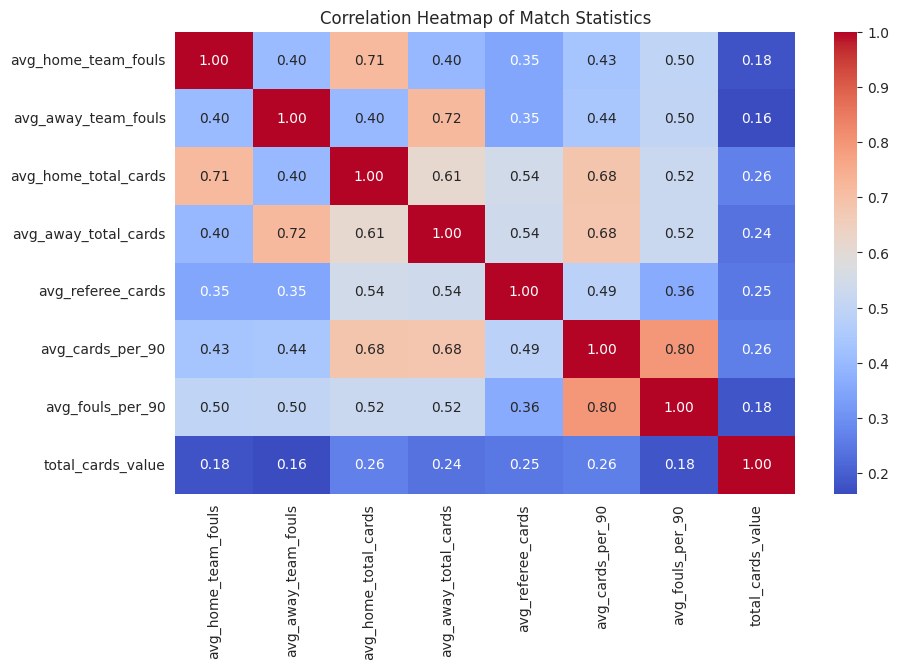

In [276]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")


# Bar Plot: Compare Fouls and Cards per Team
# df_melted = merged_final.melt(id_vars=["teams_home_name", "teams_away_name"],
#                      value_vars=["avg_home_team_fouls", "avg_away_team_fouls"],
#                      var_name="Team", value_name="Fouls")

# plt.figure(figsize=(12,6))
# sns.barplot(data=df_melted, x="teams_home_name", y="Fouls", hue="Team")
# plt.xticks(rotation=90)
# plt.title("Average Fouls per Home & Away Team")
# plt.show()


# Box Plot: Distribution of Cards per Referee
# plt.figure(figsize=(12,6))
# sns.boxplot(data=merged_final, x="fixture_referee", y="avg_referee_cards")
# plt.xticks(rotation=90)
# plt.title("Distribution of Average Cards per Referee")
# plt.show()


# Scatter Plot: Correlation Between Fouls and Cards
# plt.figure(figsize=(8,5))
# sns.scatterplot(data=merged_final, x="avg_fouls_per_90", y="avg_cards_per_90")
# plt.title("Fouls per 90 min vs Cards per 90 min")
# plt.xlabel("Avg Fouls per 90")
# plt.ylabel("Avg Cards per 90")
# plt.show()


# Heatmap: Correlation Between All Stats
plt.figure(figsize=(10,6))
sns.heatmap(merged_final.drop(["fixture_referee", "league_name", "teams_home_name", "teams_away_name"], axis=1).corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Match Statistics")
plt.show()

# Referee-Wise Total Cards Given
# plt.figure(figsize=(6, 50))
# sns.barplot(data=merged_final, x="total_cards_value", y="fixture_referee", ci=None)
# plt.xticks(rotation=0)
# plt.title("Total Cards Given by Each Referee")
# plt.show()